# Chapter 7 — Climate: A chain of identical reservoirs?

**Based on:** Chapter 7 of J.C.G. Walker, *Numerical Adventures with Geochemical Cycles*, Oxford University Press, 1991.

---

## 7.1 Overview

In Chapters 2–6, the reservoirs (atmosphere, ocean boxes) were *different* from each other — different sizes, different chemistry. In this chapter,Walker introduces a fundamentally different structure: a **chain of identical reservoirs**, each governed by the same equations but exchanging material (or energy) with their neighbours.

The application is **climate**: a one-dimensional energy balance model (EBM) of the Budyko–Sellers–North type, where the Earth's surface is divided into **latitude bands**. Each band is an identical reservoir that:

1. Absorbs solar radiation (latitude-dependent)
2. Emits infrared radiation (temperature-dependent)
3. Exchanges heat with neighbouring bands by diffusion
4. Has a temperature-dependent albedo (ice-albedo feedback)

This structure — identical reservoirs in a chain with nearest-neighbour coupling — is also how Walker discretises **vertical ocean diffusion**, the deep ocean thermohaline circulation, and any other process that can be represented as diffusion through a series of boxes.

### Chapter structure

1. The 1D energy balance model
2. Discretisation as a chain of reservoirs
3. Diffusion + GAUSS from Chapter 3
4. Ice-albedo feedback and multiple equilibria
5. The Snowball Earth catastrophe

---

## 7.2 The energy balance model

The governing equation for the zonal mean surface temperature
$T(x, t)$, where $x = \sin(\text{latitude})$, is:

$$
\begin{aligned}
C \frac{\partial T}{\partial t} &= Q \, s(x) \, [1 - \alpha(T)]
- [A + B T]
+ \frac{\partial}{\partial x}\left[D(1-x^2)\frac{\partial T}{\partial x}\right]
\end{aligned}
$$

where:

- $C$ = heat capacity (J m⁻² K⁻¹) — how much energy to warm a band by 1 K
- $Q = S_0/4$ = mean solar flux (W m⁻²), with $S_0 \approx 1367$ W m⁻²
- $s(x)$ = normalised solar distribution; $s(x) \approx 1 - 0.477 \cdot P_2(x)$ where $P_2(x) = (3x^2 - 1)/2$ is the 2nd Legendre polynomial
- $\alpha(T)$ = albedo, depending on temperature (ice-albedo feedback)
- $A + BT$ = linearised outgoing longwave radiation (OLR) with $A \approx 202$ W m⁻², $B \approx 1.9$ W m⁻² K⁻¹
- $D$ = diffusion coefficient for meridional heat transport

### The ice-albedo feedback

$$
\alpha(T) = \begin{cases}
\alpha_i = 0.62 & \text{if } T < T_{\text{ice}} = -10°\text{C} \\
\alpha_f = 0.32 & \text{if } T > T_{\text{ice}}
\end{cases}
$$

This step-function creates a **nonlinear** feedback: cold regions are ice-covered and highly reflective, keeping them cold. This is what makes the problem interesting — and what requires Walker's Newton-Raphson methods from Chapter 4.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

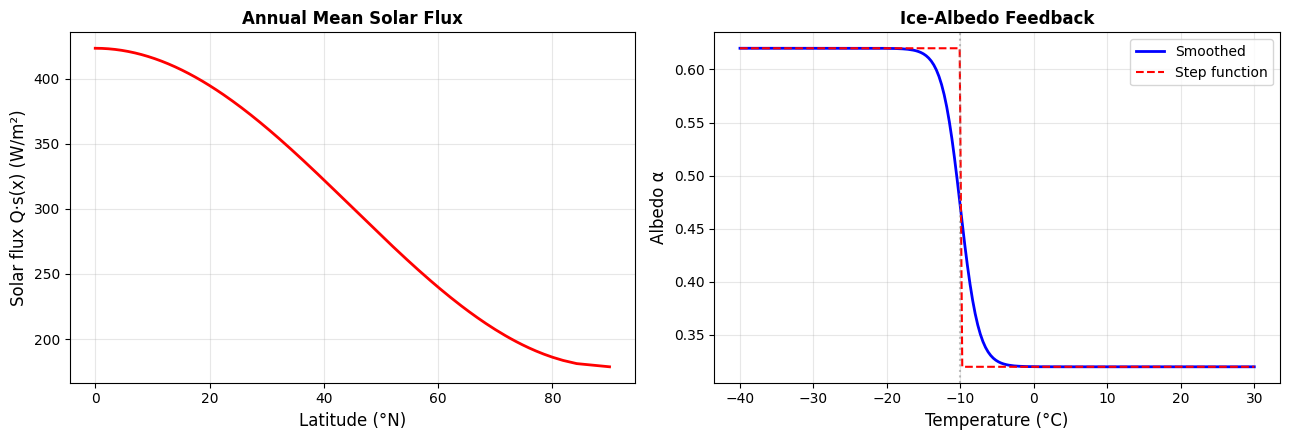

In [2]:
# ============================================================
# Physical parameters (North 1975 / Walker Ch. 7)
# ============================================================
S0 = 1367.0           # solar constant (W/m²)
Q = S0 / 4            # mean solar flux
A_olr = 202.0         # OLR constant (W/m²)
B_olr = 1.9           # OLR slope (W/m²/K)
D = 0.44              # diffusion coefficient (W/m²/K)
C_heat = 4.0e7        # heat capacity (J/m²/K), ~10 m mixed layer

alpha_ice = 0.62      # albedo of ice-covered surface
alpha_free = 0.32     # albedo of ice-free surface
T_ice = -10.0         # temperature threshold for ice (°C)

# Smoothed albedo (Walker notes the step function can cause numerical difficulty)
def albedo(T, smooth=True):
    """Temperature-dependent albedo with optional smoothing."""
    if smooth:
        # Smooth transition over ~5°C
        w = 0.5 * (1 + np.tanh((T - T_ice) / 2.5))
        return alpha_ice * (1 - w) + alpha_free * w
    else:
        return np.where(T < T_ice, alpha_ice, alpha_free)

# Solar distribution s(x) where x = sin(latitude)
def solar_distribution(x):
    """Normalised annual mean insolation.
    s(x) ≈ 1 - 0.477 * P2(x), where P2 is 2nd Legendre polynomial.
    """
    P2 = (3 * x**2 - 1) / 2
    return 1 - 0.477 * P2

# Plot solar distribution
x_plot = np.linspace(0, 1, 200)  # equator (0) to pole (1)
lat_plot = np.degrees(np.arcsin(x_plot))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))

ax1.plot(lat_plot, Q * solar_distribution(x_plot), 'r-', linewidth=2)
ax1.set_xlabel('Latitude (°N)', fontsize=12)
ax1.set_ylabel('Solar flux Q·s(x) (W/m²)', fontsize=12)
ax1.set_title('Annual Mean Solar Flux', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

T_range = np.linspace(-40, 30, 200)
ax2.plot(T_range, albedo(T_range, smooth=True), 'b-', linewidth=2, label='Smoothed')
ax2.plot(T_range, albedo(T_range, smooth=False), 'r--', linewidth=1.5, label='Step function')
ax2.axvline(x=T_ice, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Temperature (°C)', fontsize=12)
ax2.set_ylabel('Albedo α', fontsize=12)
ax2.set_title('Ice-Albedo Feedback', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 7.3 Discretisation: The chain of reservoirs

Walker discretises the sphere into $N$ latitude bands (symmetric about the equator), each centred at $x_i = \sin(\theta_i)$. The diffusion term becomes nearest-neighbour coupling:

$$
\begin{aligned}
C \frac{dT_i}{dt} &= Q \, s(x_i) \, [1 - \alpha(T_i)]
- [A + B T_i] \\
&\quad + \frac{D}{(\Delta x)^2}\left[
  (1 - x_{i+1/2}^2)(T_{i+1} - T_i)
  - (1 - x_{i-1/2}^2)(T_i - T_{i-1})
\right]
\end{aligned}
$$

with boundary conditions $\partial T / \partial x = 0$ at the equator ($x = 0$) and pole ($x = 1$).

This replicates the structure from Chapter 3: a system of coupled ODEs with tridiagonal coupling (each band only talks to its neighbours). The "identical reservoirs" are the latitude bands, each governed by the same physics.

In [3]:
# ============================================================
# Discretisation: N latitude bands (equator to pole)
# ============================================================
N = 20  # number of bands
dx = 1.0 / N
x = np.linspace(dx/2, 1 - dx/2, N)  # band centres (x = sin(lat))
lat = np.degrees(np.arcsin(x))       # latitudes in degrees

# Interface positions (between bands)
x_edge = np.linspace(0, 1, N + 1)

# Diffusion coefficients at interfaces: D * (1 - x²)
diff_coeff = D * (1 - x_edge**2) / dx**2

print(f"Number of latitude bands: {N}")
print(f"Band width: Δx = {dx:.3f}")
print(f"Latitudes: {lat[0]:.1f}° to {lat[-1]:.1f}°")

def compute_rhs(T, Q_factor=1.0):
    """Right-hand side of the energy balance ODE system.
    
    T: array of temperatures for each latitude band (°C)
    Q_factor: multiplicative factor on solar constant (1.0 = present)
    Returns: dT/dt for each band (K/s → multiply by C_heat to get W/m²)
    """
    n = len(T)
    dTdt = np.zeros(n)
    
    for i in range(n):
        # Solar absorption
        solar = Q_factor * Q * solar_distribution(x[i]) * (1 - albedo(T[i]))
        
        # Outgoing longwave
        olr = A_olr + B_olr * T[i]
        
        # Diffusion (nearest-neighbour heat exchange)
        diff = 0.0
        if i < n - 1:  # flux from band i+1
            diff += diff_coeff[i + 1] * (T[i + 1] - T[i])
        if i > 0:       # flux from band i-1
            diff += diff_coeff[i] * (T[i - 1] - T[i])
        # Boundary: no flux at equator (i=0 boundary) and pole (i=N-1 boundary)
        # Already handled: diff_coeff[0] has x_edge=0, so (1-0²)=1 → no special case needed
        # At pole: diff_coeff[N] has x_edge=1, so (1-1²)=0 → zero flux automatically
        
        dTdt[i] = (solar - olr + diff) / C_heat
    
    return dTdt

Number of latitude bands: 20
Band width: Δx = 0.050
Latitudes: 1.4° to 77.2°


---

## 7.4 Why forward Euler fails here

The diffusion term creates a **stiff** system: with $N = 20$ bands, the maximum diffusion coefficient is ~176 W/m²/K, giving a CFL stability limit of only ~0.004 years. This is a perfect example of Walker's motivation for the reverse Euler; explicit methods need impractically small time steps for diffusive problems.

In [4]:
def reverse_euler_step(T, dt, Q_factor=1.0, tol=1e-10, max_newton=10):
    """One reverse Euler step with Newton-Raphson (Walker's method)."""
    n = len(T)
    I = np.eye(n)
    T_k = T.copy()
    
    for k in range(max_newton):
        f_k = compute_rhs(T_k, Q_factor)
        g_k = T_k - T - dt * f_k
        
        if np.max(np.abs(g_k)) < tol:
            return T_k, k + 1
        
        # Numerical Jacobian
        J = np.zeros((n, n))
        for j in range(n):
            dT = np.zeros(n)
            h = max(abs(T_k[j]) * 1e-6, 1e-8)
            dT[j] = h
            J[:, j] = (compute_rhs(T_k + dT, Q_factor) - f_k) / h
        
        J_g = I - dt * J
        delta = np.linalg.solve(J_g, -g_k)
        T_k = T_k + delta
    
    return T_k, max_newton


def integrate_climate(T0, dt_yr, n_years, Q_factor=1.0):
    """Integrate the EBM using reverse Euler."""
    dt = 3.15e7 * dt_yr
    n_steps = int(n_years / dt_yr)
    T = T0.copy()
    T_history = [T.copy()]
    for step in range(n_steps):
        T, _ = reverse_euler_step(T, dt, Q_factor)
        T_history.append(T.copy())
    return np.array(T_history)


# === Demonstrate forward Euler instability ===
T_init = np.full(N, 15.0)
dt_fe = 3.15e7 * 0.1  # 0.1 yr — above CFL limit of ~0.004 yr
T_fe = T_init.copy()
for step in range(5):
    T_fe = T_fe + dt_fe * compute_rhs(T_fe)
print(f"Forward Euler (dt=0.1 yr): after 5 steps, max|T| = {np.max(np.abs(T_fe)):.1e}")
print(f"  UNSTABLE! (CFL limit ~ 0.004 yr for this diffusion)")

# === Reverse Euler with dt = 1 yr (250x larger!) ===
print(f"\nReverse Euler (dt=1 yr): integrating 30 years...")
T_hist = integrate_climate(T_init, dt_yr=1.0, n_years=30)
T_final = T_hist[-1]
print(f"  Global mean: {np.mean(T_final):.1f} C — Stable!")
print(f"  Equator: {T_final[0]:.1f} C, Pole: {T_final[-1]:.1f} C")

Forward Euler (dt=0.1 yr): after 5 steps, max|T| = 2.6e+01
  UNSTABLE! (CFL limit ~ 0.004 yr for this diffusion)

Reverse Euler (dt=1 yr): integrating 30 years...
  Global mean: 15.8 C — Stable!
  Equator: 28.1 C, Pole: -7.3 C


---

## 7.5 Reverse Euler + Newton-Raphson for steady state

Walker's preferred approach: use the reverse Euler with Newton-Raphson to find the steady state directly. At steady state, $dT/dt = 0$, so we need to solve:

$$
\mathbf{f}(\mathbf{T}) = \mathbf{0}
$$

This is a nonlinear system (because of the albedo) that we solve with Newton-Raphson, using a numerical Jacobian and Gaussian elimination.

In [5]:
def gauss_eliminate(A, b):
    """Walker's GAUSS subroutine: Gaussian elimination with partial pivoting."""
    n = len(b)
    M = np.hstack([A.astype(float), b.reshape(-1, 1).astype(float)])
    
    for k in range(n):
        # Partial pivoting
        max_row = k + np.argmax(np.abs(M[k:, k]))
        M[[k, max_row]] = M[[max_row, k]]
        
        # Forward elimination
        for i in range(k + 1, n):
            factor = M[i, k] / M[k, k]
            M[i, k:] -= factor * M[k, k:]
    
    # Back substitution
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (M[i, -1] - np.dot(M[i, i+1:n], x[i+1:n])) / M[i, i]
    
    return x


def numerical_jacobian(f, T, Q_factor=1.0):
    """Compute Jacobian df/dT by finite differences."""
    n = len(T)
    J = np.zeros((n, n))
    f0 = f(T, Q_factor)
    for j in range(n):
        dT = np.zeros(n)
        h = max(abs(T[j]) * 1e-6, 1e-8)
        dT[j] = h
        J[:, j] = (f(T + dT, Q_factor) - f0) / h
    return J


def find_steady_state(T_guess, Q_factor=1.0, tol=1e-8, max_iter=100):
    """Newton-Raphson to find steady state: f(T) = 0."""
    T = T_guess.copy()
    
    for k in range(max_iter):
        f = compute_rhs(T, Q_factor) * C_heat  # W/m² residual
        
        if np.max(np.abs(f)) < tol:
            return T, k + 1
        
        J = numerical_jacobian(lambda T, Q: compute_rhs(T, Q) * C_heat,
                               T, Q_factor)
        delta_T = gauss_eliminate(J, -f)
        T = T + delta_T
    
    return T, max_iter

# Find present-day steady state
T_ss, n_iter = find_steady_state(T_init, Q_factor=1.0)
print(f"Steady state found in {n_iter} Newton iterations")
print(f"Global mean: {np.mean(T_ss):.1f}°C")
print(f"Equator: {T_ss[0]:.1f}°C, Pole: {T_ss[-1]:.1f}°C")

# Verify: residual should be tiny
residual = compute_rhs(T_ss) * C_heat
print(f"Max residual: {np.max(np.abs(residual)):.2e} W/m²")

Steady state found in 6 Newton iterations
Global mean: 15.8°C
Equator: 28.1°C, Pole: -7.3°C
Max residual: 4.71e-11 W/m²


---

## 7.6 Experiment 1: Climate sensitivity to CO₂

Increasing CO₂ reduces the OLR (the atmosphere traps more infrared). In this model, this is represented by decreasing the parameter $A$. A CO₂ doubling corresponds to a radiative forcing of ~3.7 W/m², equivalent to decreasing $A$ by 3.7.

In [6]:
# Climate sensitivity experiment
A_olr_orig = A_olr
dA_values = np.linspace(0, -15, 20)
T_global_list = []
T_profiles = []
dt_sens = 3.15e7 * 1.0  # 1 yr

for dA in dA_values:
    A_val = A_olr_orig + dA
    
    def rhs_mod(T, Q_factor=1.0):
        n = len(T)
        dTdt = np.zeros(n)
        for i in range(n):
            solar = Q_factor * Q * solar_distribution(x[i]) * (1 - albedo(T[i]))
            olr = A_val + B_olr * T[i]
            diff = 0.0
            if i < n-1: diff += diff_coeff[i+1]*(T[i+1]-T[i])
            if i > 0:   diff += diff_coeff[i]*(T[i-1]-T[i])
            dTdt[i] = (solar - olr + diff) / C_heat
        return dTdt
    
    # Newton-Raphson steady state (direct)
    T = T_final.copy()
    for k in range(50):
        f = rhs_mod(T) * C_heat
        if np.max(np.abs(f)) < 1e-6: break
        J = np.zeros((N,N))
        for j in range(N):
            dT = np.zeros(N); h = max(abs(T[j])*1e-6, 1e-8); dT[j] = h
            J[:,j] = (rhs_mod(T+dT)*C_heat - f) / h
        T = T + np.linalg.solve(J, -f)
    
    T_global_list.append(np.mean(T))
    T_profiles.append(T.copy())

A_olr = A_olr_orig  # restore

---

## 7.7 Experiment 2: The Ice-Albedo catastrophe

The most dramatic result of the 1D EBM: if the solar constant is reduced sufficiently, the ice line advances to low latitudes and a **runaway albedo feedback** kicks in. The ice grows unstably until the entire planet freezes (**Snowball Earth**).

We scan the solar constant and find the steady-state ice-line latitude.

In [7]:
# Scan solar constant: reduce from present (reverse Euler, dt=1 yr)
Q_factors_down = np.linspace(1.0, 0.90, 30)

ice_edge_down = []
T_global_down = []
T_current = T_final.copy()
dt_hyst = 3.15e7 * 1.0  # 1 yr steps

for Q_f in Q_factors_down:
    # Equilibrate for 30 years at each Q
    for step in range(30):
        T_current, _ = reverse_euler_step(T_current, dt_hyst, Q_f)
    
    T_global_down.append(np.mean(T_current))
    frozen = T_current < T_ice
    if np.all(frozen):
        ice_edge_down.append(0.0)
    elif np.any(frozen):
        ice_edge_down.append(lat[np.argmax(frozen)])
    else:
        ice_edge_down.append(90.0)

# Warming from Snowball
Q_factors_up = np.linspace(0.90, 1.30, 40)
ice_edge_up = []
T_global_up = []
T_cold = np.full(N, -40.0)

for Q_f in Q_factors_up:
    for step in range(30):
        T_cold, _ = reverse_euler_step(T_cold, dt_hyst, Q_f)
    
    T_global_up.append(np.mean(T_cold))
    frozen = T_cold < T_ice
    if np.all(frozen):
        ice_edge_up.append(0.0)
    elif np.any(frozen):
        ice_edge_up.append(lat[np.argmax(frozen)])
    else:
        ice_edge_up.append(90.0)

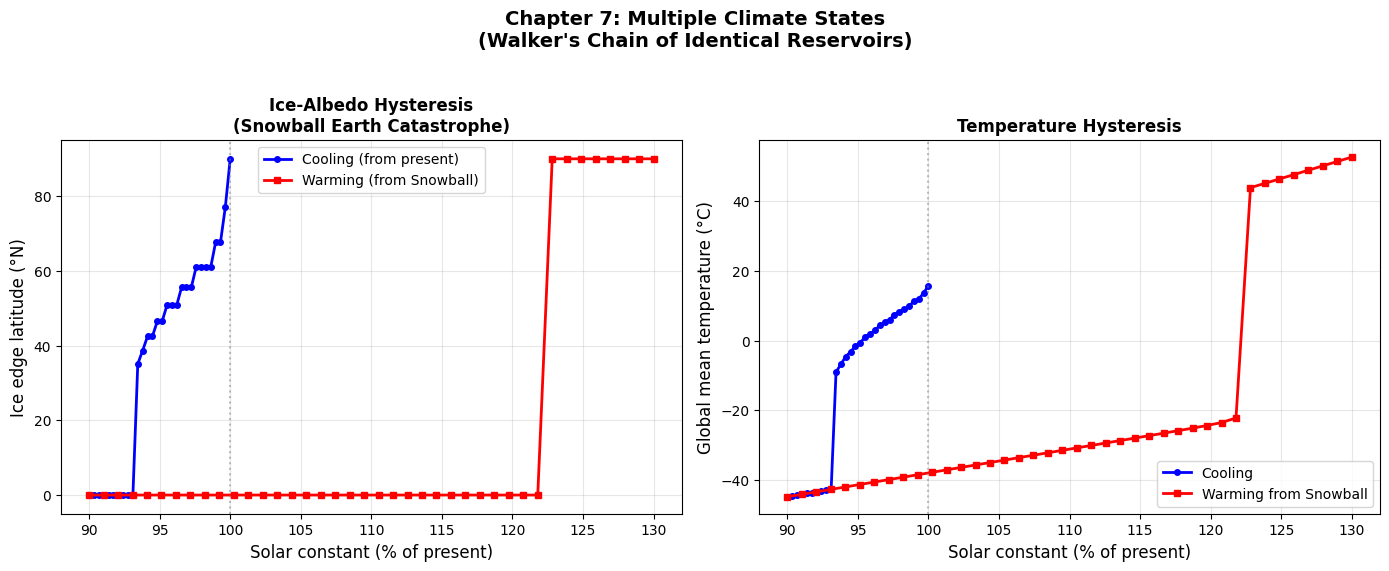

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5.5))

ax1.plot(Q_factors_down * 100, ice_edge_down, 'b-o', markersize=4,
         linewidth=2, label='Cooling (from present)')
ax1.plot(Q_factors_up * 100, ice_edge_up, 'r-s', markersize=4,
         linewidth=2, label='Warming (from Snowball)')
ax1.axvline(x=100, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Solar constant (% of present)', fontsize=12)
ax1.set_ylabel('Ice edge latitude (°N)', fontsize=12)
ax1.set_title('Ice-Albedo Hysteresis\n(Snowball Earth Catastrophe)',
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-5, 95)

ax2.plot(Q_factors_down * 100, T_global_down, 'b-o', markersize=4,
         linewidth=2, label='Cooling')
ax2.plot(Q_factors_up * 100, T_global_up, 'r-s', markersize=4,
         linewidth=2, label='Warming from Snowball')
ax2.axvline(x=100, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Solar constant (% of present)', fontsize=12)
ax2.set_ylabel('Global mean temperature (°C)', fontsize=12)
ax2.set_title('Temperature Hysteresis', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

fig.suptitle('Chapter 7: Multiple Climate States\n'
             '(Walker\'s Chain of Identical Reservoirs)',
             fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

### The key result: hysteresis and multiple equilibria

**Cooling from present**: as the solar constant decreases, the ice edge advances gradually until a critical threshold where the runaway ice-albedo feedback drives the planet into a Snowball state.

**Warming from Snowball**: it takes a *much larger* increase in solar radiation (or CO₂) to escape from the Snowball state, because the entire planet is highly reflective.

This **hysteresis** means the system has **multiple stable states** for the same solar constant, a warm state with partial ice and a Snowball state. Walker emphasises that this emerges naturally from the nonlinear ice-albedo feedback and would be missed by a linear model.

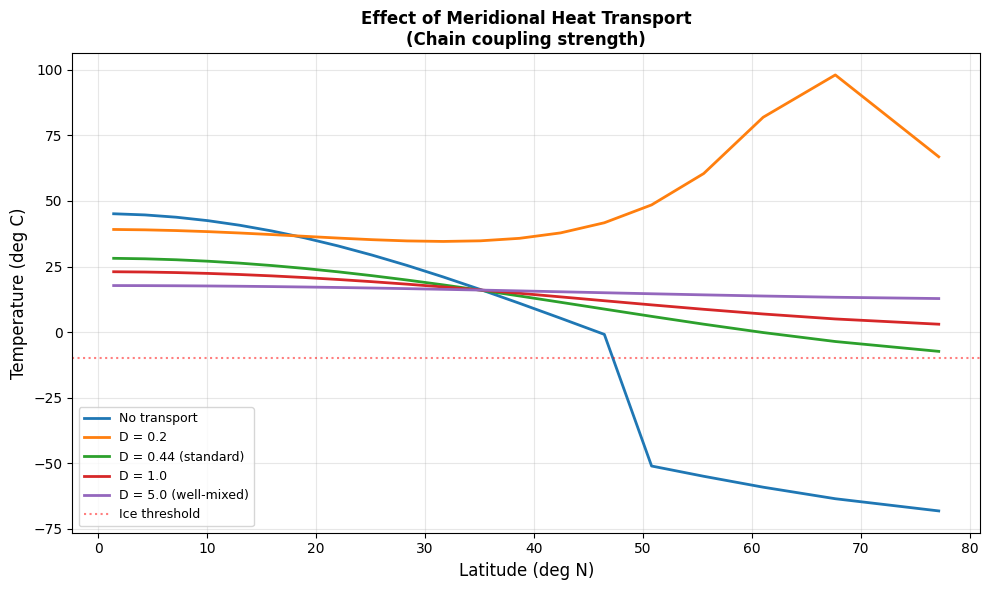

In [9]:
D_values = [0.0, 0.2, 0.44, 1.0, 5.0]
D_labels = ['No transport', 'D = 0.2', 'D = 0.44 (standard)',
            'D = 1.0', 'D = 5.0 (well-mixed)']

fig, ax = plt.subplots(figsize=(10, 6))

for D_val, lab in zip(D_values, D_labels):
    dc = D_val * (1 - x_edge**2) / dx**2
    
    def rhs_D(T, Q_factor=1.0):
        n = len(T)
        dTdt = np.zeros(n)
        for i in range(n):
            solar = Q_factor * Q * solar_distribution(x[i]) * (1 - albedo(T[i]))
            olr = A_olr + B_olr * T[i]
            diff = 0.0
            if i < n-1: diff += dc[i+1]*(T[i+1]-T[i])
            if i > 0:   diff += dc[i]*(T[i-1]-T[i])
            dTdt[i] = (solar - olr + diff) / C_heat
        return dTdt
    
    # Newton-Raphson steady state
    T = np.full(N, 15.0)
    for k in range(80):
        f = rhs_D(T) * C_heat
        if np.max(np.abs(f)) < 1e-6: break
        J = np.zeros((N,N))
        for j in range(N):
            dT = np.zeros(N); h = max(abs(T[j])*1e-6, 1e-8); dT[j] = h
            J[:,j] = (rhs_D(T+dT)*C_heat - f) / h
        T = T + np.linalg.solve(J, -f)
    
    ax.plot(lat, T, linewidth=2, label=lab)

ax.axhline(y=T_ice, color='red', linestyle=':', alpha=0.5, label='Ice threshold')
ax.set_xlabel('Latitude (deg N)', fontsize=12)
ax.set_ylabel('Temperature (deg C)', fontsize=12)
ax.set_title('Effect of Meridional Heat Transport\n'
             '(Chain coupling strength)',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='lower left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**No transport** ($D = 0$): each band is independent; the equator is very hot, the poles are frozen. This is the "radiative equilibrium" limit. 

**Strong transport** ($D$ large): heat is efficiently redistributed; temperature is nearly uniform. This is the "well-mixed" limit.

The real Earth ($D \approx 0.44$) is between these extremes. Walker notes that $D$ is one of the most important parameters in the model, it controls both the equator-to-pole gradient and the stability of the ice caps.

---

## 7.9 Connection to geochemical cycles

Walker's main point: this same "chain of identical reservoirs" structure applies to **vertical ocean mixing**, where depth layers exchange tracers by diffusion. A 1D diffusion column in the ocean is mathematically identical to the latitude bands in this climate model. The same code — tridiagonal coupling + GAUSS + reverse Euler — works for both.

This connects the climate model directly to the ocean carbon cycle of earlier chapters: vertical diffusion of DIC and ¹³C through the ocean interior is solved by exactly the same chain-of-reservoirs approach.

---

## 7.10 Exercises

**Exercise 7.1:** Implement the reverse Euler + Newton-Raphson for the time-dependent EBM (not just steady state). Use a large time step (e.g., 1 year) and show that the implicit method converges while the forward Euler with the same step may be unstable (especially with small $C$).

**Exercise 7.2:** Add a seasonal cycle. Replace the constant $s(x)$ with a time-varying $s(x, t)$ that depends on solar declination. How does the seasonally averaged climate differ from the annual-mean calculation? (Hint: the nonlinear albedo feedback means the average of the seasonal cycle ≠ the annual-mean solution.)

**Exercise 7.3:** Couple the EBM to the carbon cycle. Let the OLR parameter $A$ depend on atmospheric CO₂ (from Chapter 5), and let silicate weathering (which removes CO₂) depend on temperature. Show that this negative feedback stabilises the climate against the ice-albedo catastrophe (Walker's own research area).

**Exercise 7.4:** Apply the chain-of-identical-reservoirs approach to vertical ocean diffusion. Create a 1D column of 20 depth layers, each 200 m thick, with vertical diffusivity $K_v = 10^{-4}$ m²/s. Inject a tracer at the surface and watch it diffuse downward. Compare with the multi-box model from Chapter 3.

**Exercise 7.5:** Explore the "faint young Sun paradox". The Sun was ~30% dimmer 4 billion years ago. Show that the EBM predicts a Snowball Earth — but we know liquid water existed. Walker's resolution: higher CO₂ from weaker silicate weathering (Exercise 7.3 connection).

---

## References

- Walker, J.C.G. (1991). *Numerical Adventures with Geochemical Cycles*. Oxford University Press. Chapter 7: "Climate: A Chain of Identical Reservoirs."
- North, G.R. (1975). Analytical solution to a simple climate model with diffusive heat transport. *J. Atmos. Sci.*, 32, 1301–1307.
- Budyko, M.I. (1969). The effect of solar radiation variations on the climate of the earth. *Tellus*, 21, 611–619.
- Sellers, W.D. (1969). A climate model based on the energy balance of the earth-atmosphere system. *J. Appl. Meteorol.*, 8, 392–400.
- Walker, J.C.G., Hays, P.B., and Kasting, J.F. (1981). A negative feedback mechanism for the long-term stabilization of Earth's surface temperature. *J. Geophys. Res.*, 86, 9776–9782.